In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [39]:
class Value:
    def __init__(self, data, _children =(), _op ='', label = "", grad = 0.0):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad
        self._backward = lambda: None

    def __repr__(self):
        return f"Value (data={self.data}, label={self.label})"

    def __add__(self,other):
        op = Value(self.data + other.data, (self, other), '+', self.label)

        def _backward():
            self.grad = 1.0 * op.grad
            other.grad = 1.0 * op.grad

        op._backward = _backward 
        return op

    def __mul__(self, other):
        op = Value(self.data * other.data, (self, other), '*', self.label)

        def _backward():
            self.grad = other.data * op.grad
            other.grad = self.data * op.grad

        op._backward = _backward
        return op

    def tanh(self):
        x = self.data
        n = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        op = Value(n, (self,), 'tanh')

        def _backward():
            self.grad = (1-n**2)*op.grad
        
        op._backward = _backward    
        return op

In [37]:
a = Value(2.0, label = 'a', grad = 6.0)
b = Value(-3.0, label = 'b', grad = -4.0)
c = Value(10.0, label = 'c', grad = -2.0)
f = Value(-2.0, label = 'f', grad = 4.0)
print(a)
print(b)
print(c)
e = a*b; e.label = 'e';e.grad = -2.0
d = e + c
d.label = 'd'
d.grad = -2.0
print(d)
L = f*d
L.grad = 1
L.label = 'L'

Value (data=2.0, label=a)
Value (data=-3.0, label=b)
Value (data=10.0, label=c)
Value (data=4.0, label=d)


In [21]:
from graphviz import Digraph

def trace(root):
    #builds set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR signifies Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %f}" % (n.label, n.data, n.grad, ), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

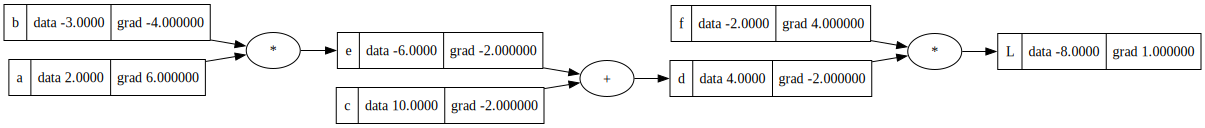

In [24]:
draw_dot(L)

In [38]:
#Checking the partial derivative of L w.r.t. a
a.data += 1

print(a)
e.data = a.data * b.data
print(e)
d.data = e.data + c.data
L.data = f.data * d.data

print(L)

Value (data=3.0, label=a)
Value (data=-9.0, label=e)
Value (data=-2.0, label=L)
